In [1]:
from os import listdir

import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt

import seaborn as sns

from scipy import optimize
from scipy import stats

# Define functions

In [9]:
def six_column(df):
    
    assert (df.columns == ['Frame', 'Mean(Focus)','Mean(Spot)', 'Mean(Bgd)',
       'Mean(Control_Focus)', 'Mean(Control_Spot)',
       'Protein', 'File', 'Filename', 'Experiment', 'Bleach Frame']).all()
    
    six_columns = df.iloc[:,0:6]
    
    return six_columns

In [44]:
def four_column(df):
    
    assert (df.columns == ['Frame', 'Mean(Focus)','Mean(Spot)', 'Mean(Bgd)',
       'Mean(Control_Focus)', 'Mean(Control_Spot)',
       'Protein', 'File', 'Filename', 'Experiment', 'Bleach Frame']).all()
    
    four_columns = df.iloc[:,0:4]
    
    return four_columns

In [10]:
def prebleach(df):
    
    pre = df.iloc[0:6,1:].mean()
    pre = pd.DataFrame(pre).T
    
    return pre

In [11]:
def subtract_background(df: pd.DataFrame):
    ''''''
    
    sub = df.subtract(df['Mean(Bgd)'], axis=0)
    sub.Frame = df.Frame
    sub.drop(columns='Mean(Bgd)', inplace=True)
    return sub

In [12]:
def normalise(sub: pd.DataFrame):
    ''''''
    
    pre = prebleach(sub)
    
    norm = pd.DataFrame()

    for key, value in pre.to_dict(orient='index')[0].items():
    #     print(key, value)

        norm[str(key)] = sub.loc[:, key].divide(value)

    norm['Frame'] = sub['Frame']
    
    return norm

In [13]:
def get_FRAP(norm: pd.DataFrame, t0: int):
    '''
    Parameters
    ----
    norm: pd.DataFrame
    To calculate fluorescence recovery get_FRAP uses a normalised input
    
    t0: int 
    The first postbleach frame. This is used to set the 'Time' column
    
    Returns
    ----
    FRAP: pd.DataFrame
    '''
    
    FRAP = norm.copy() #Here FRAP is NOT cropped
    FRAP['Time'] = (FRAP['Frame']-t0)
    
    return FRAP

In [17]:
def exp_curve(x, A, c, h):
    
    y = h - A*(np.exp(-x/c))
    
    return y

In [18]:
def fit_exp(x, y0, p0, bounds):
    
    #ensure array-like structure
#     x = np.array(x)
#     y = np.array(y0)

    p , e = optimize.curve_fit(f = exp_curve, xdata=x, ydata=y0, p0=p0, bounds=bounds)

    A, c, h = p

    fit = exp_curve(x, A, c, h)

    return fit, p, e

In [236]:
def exp_inv(y, A, c, h):
    
    #numpy.log   is the natural log. 
    #numpy.log10 is log10
    
#     y = h - A*(np.exp(-x/c))
#     y + A*(np.exp(-x/c)) =           h
#         A*(np.exp(-x/c)) =           h - y
#             np.exp(-x/c) =          (h - y)/A
#             np.exp(-x/c) =          (h - y)/A
#                    -x/c  =    np.ln((h - y)/A)
#                    -x    =  c*np.ln((h - y)/A)
    x1    = -c*np.log((h - y)/A)                
    
    return x1

In [20]:
def get_mobile_from_fit(y1):
    
    v  = y1.max()
    F0 = y1.min()
    M  = (v - F0)/(1-F0)
    
    return M

In [21]:
def get_thalf(x, y1):
    
    y1_range = y1.max()-y1.min()
    y1_range

    y1_half = y1.min()+y1_range/2

    #what is x at y0_half?
    A, c, h = p1
    thalf = exp_inv(y1_half, A, c, h)
    
    return thalf

# Load data

In [205]:
# Load locally
publication_data = pd.read_pickle("C:/Users/David Brown/Documents/Huang Lab/EML4-ALK_1fps_publication_data_df.pkl")

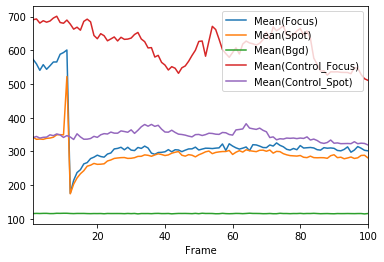

In [206]:
file_num = 62

file_data = publication_data[publication_data.File.eq(file_num)]
file_data.plot(x='Frame');

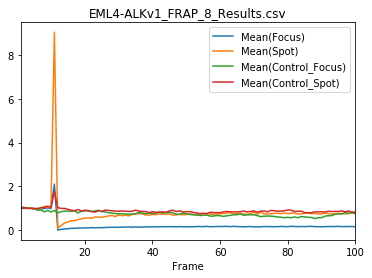

In [210]:
file_num = 12

file_data = publication_data[publication_data.File.eq(file_num)]

title = file_data.Filename.values[0]
t0    = file_data['Bleach Frame'].values[0]

df    = six_column(file_data)
sub   = subtract_background(df)
norm  = normalise(sub)

norm.plot(x='Frame');
plt.title(title);

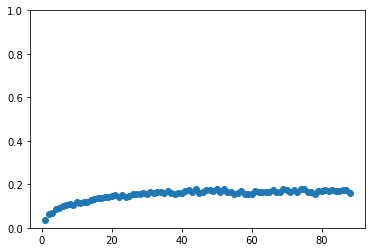

In [211]:
ROI = 'Mean(Focus)'

post_bleach = norm[t0:].copy()
post_bleach['Time'] = (post_bleach['Frame']-t0)
plt.scatter(x=post_bleach['Time'], y=post_bleach[ROI]);
plt.ylim(0,1);

In [143]:
## What happens as we cycle through the files?
publication_data.File.cat.categories

Int64Index([ 0,  2,  3,  4,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
            20, 21, 30, 31, 32, 35, 36, 37, 39, 41, 42, 43, 44, 45, 46, 56, 57,
            58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73],
           dtype='int64')

In [212]:
ALKv1 = publication_data[publication_data.Protein.eq('ALKv1')]

C:\Users\PythonWork\envs\computerVision\lib\site-packages\pandas\plotting\_matplotlib\core.py:338: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


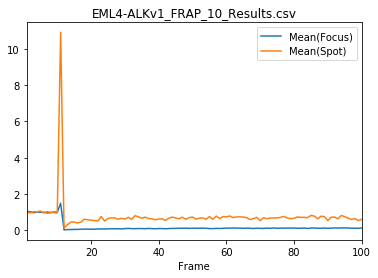

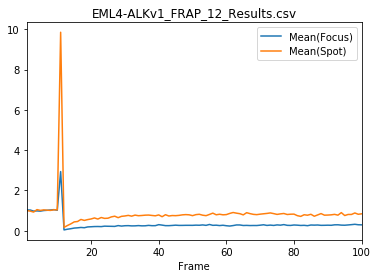

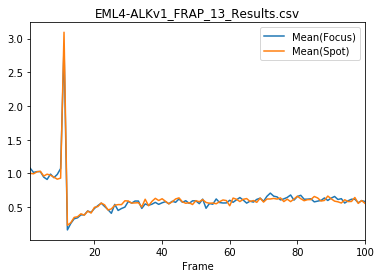

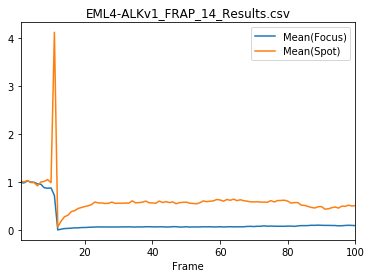

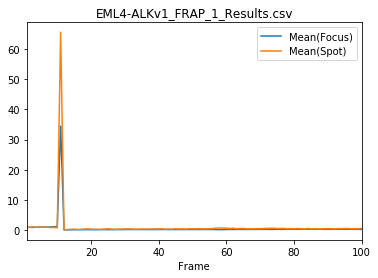

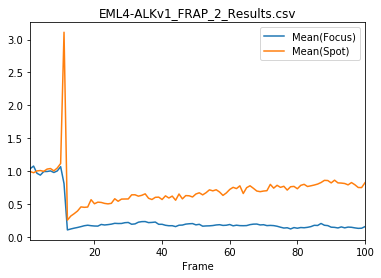

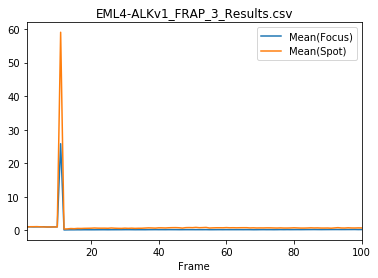

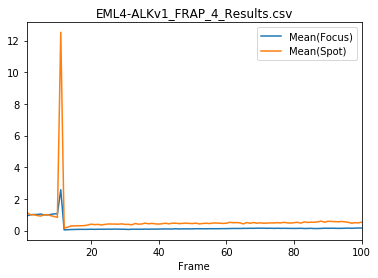

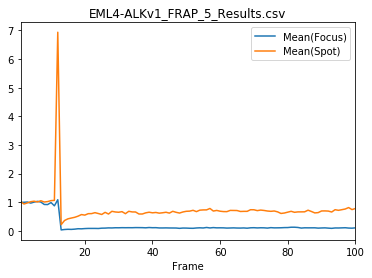

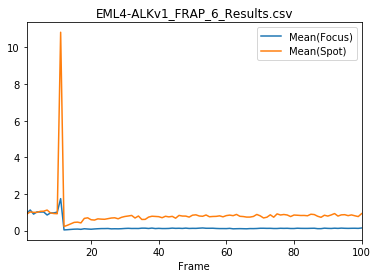

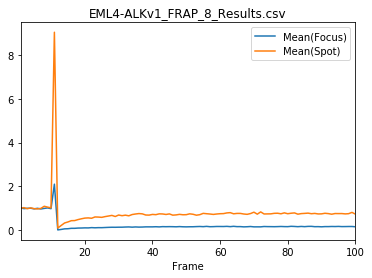

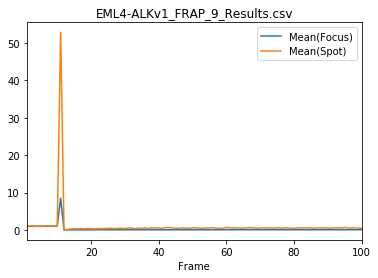

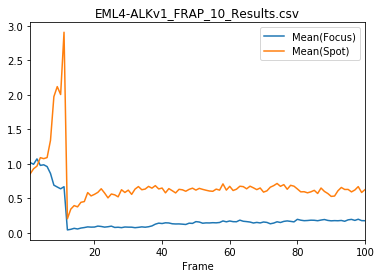

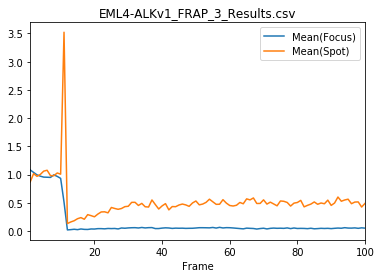

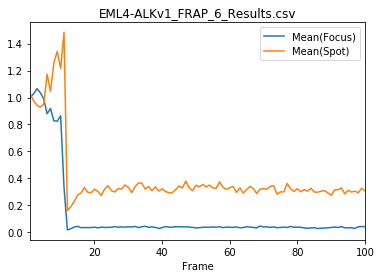

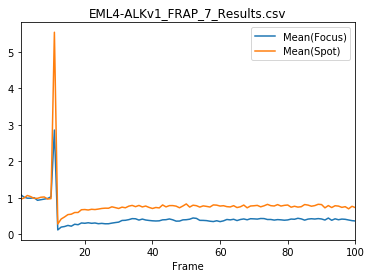

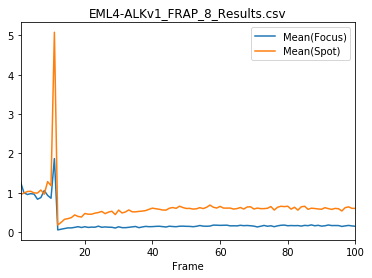

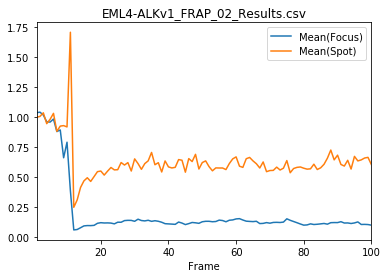

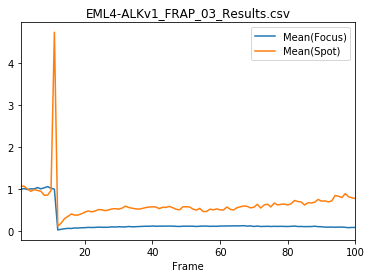

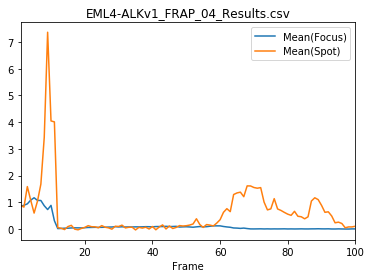

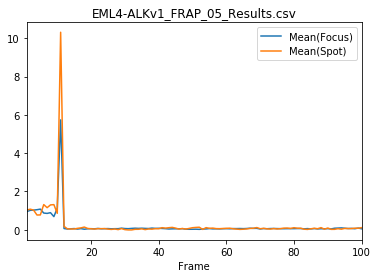

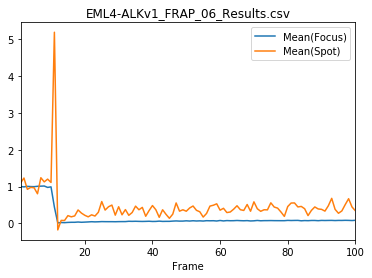

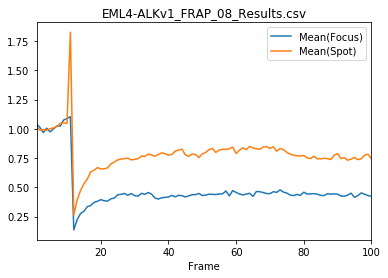

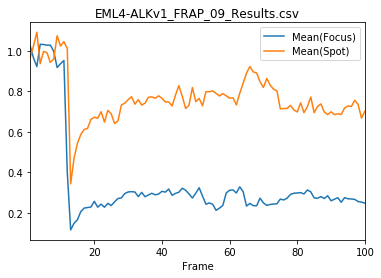

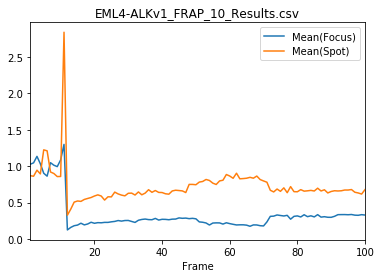

In [213]:
for f in ALKv1.File.unique():
    
    file_data = ALKv1[ALKv1.File.eq(f)]

    title = file_data.Filename.values[0]
    t0    = file_data['Bleach Frame'].values[0]

    df    = four_column(file_data)
    sub   = subtract_background(df)
    norm  = normalise(sub)

    norm.plot(x='Frame');
    plt.title(title);

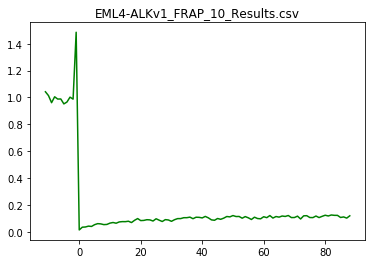

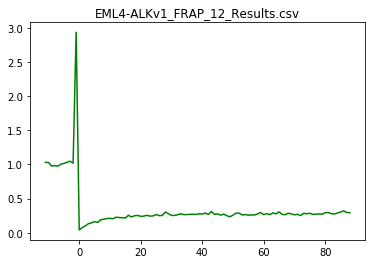

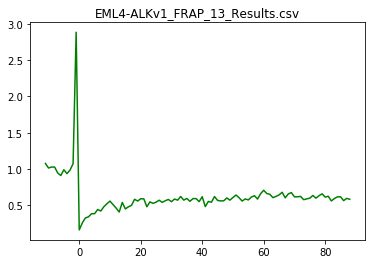

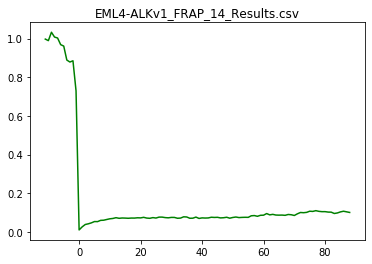

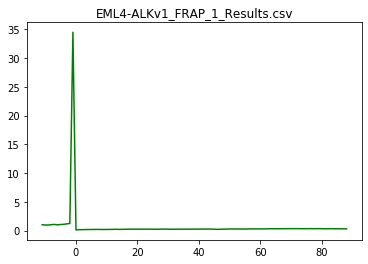

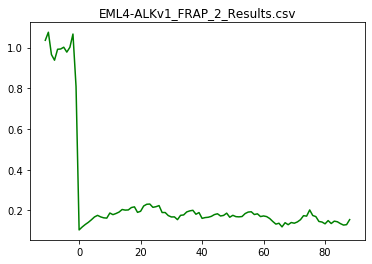

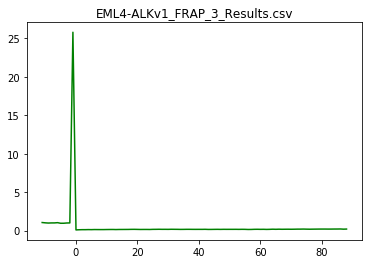

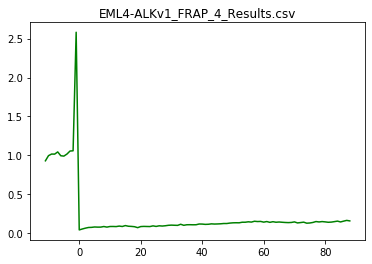

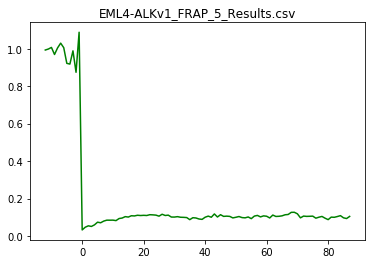

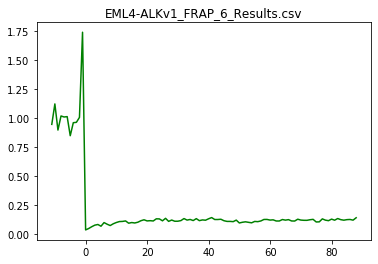

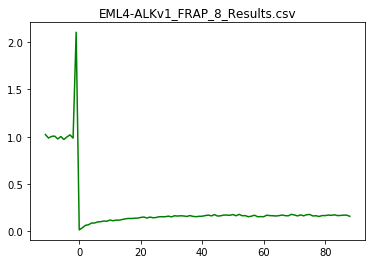

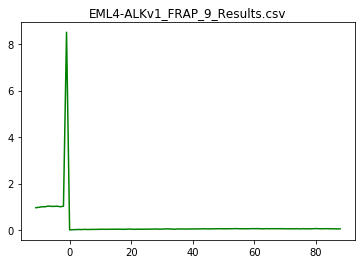

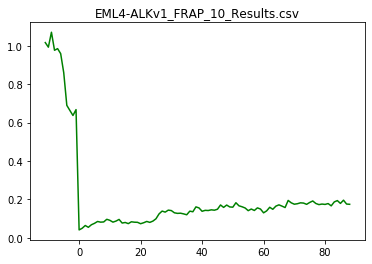

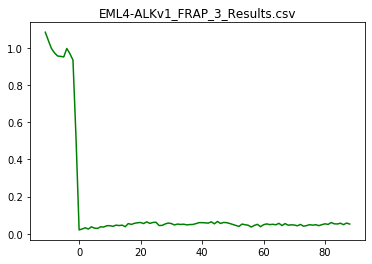

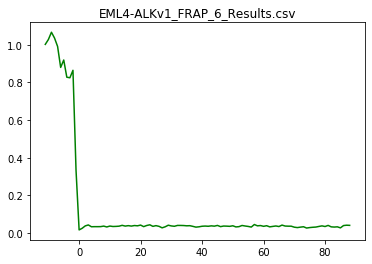

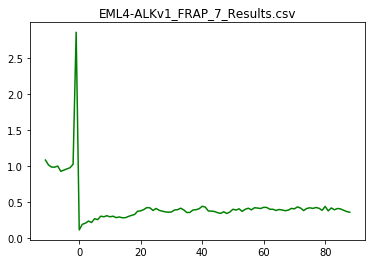

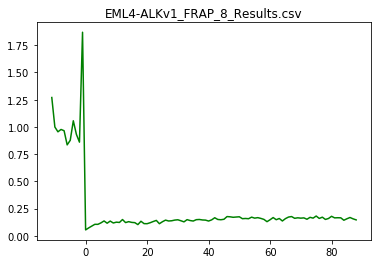

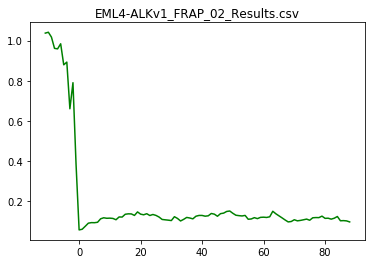

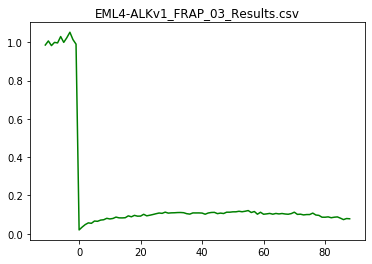

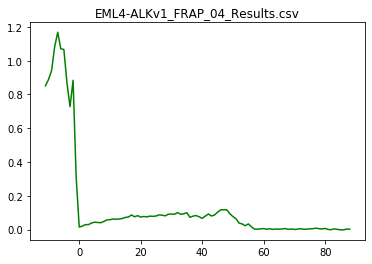

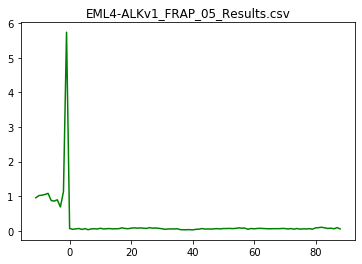

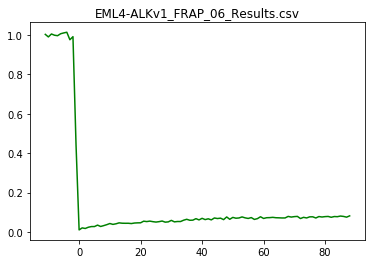

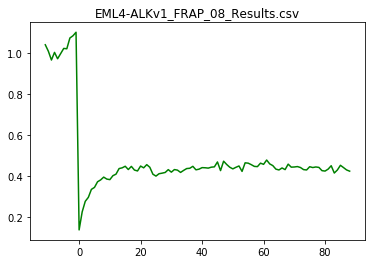

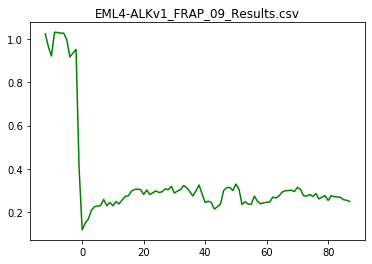

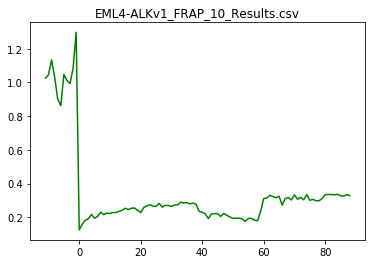

In [214]:
ROI = 'Mean(Focus)'

for f in ALKv1.File.unique():
    
    file_data = ALKv1[ALKv1.File.eq(f)]

    title = file_data.Filename.values[0]
    t0    = file_data['Bleach Frame'].values[0]
    
    df    = four_column(file_data)
    sub   = subtract_background(df)
    norm  = normalise(sub)
    FRAP = get_FRAP(norm, t0)

    x = FRAP.Time
    y = FRAP[ROI]
    plt.plot(FRAP['Time'], FRAP[ROI], c='g');
    plt.title(title);
    plt.show()

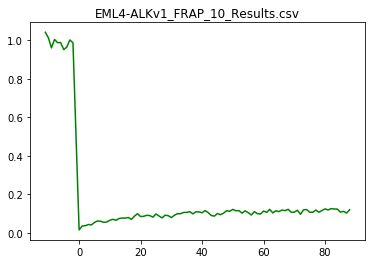

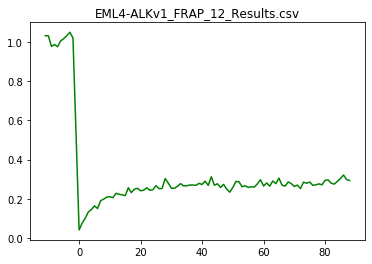

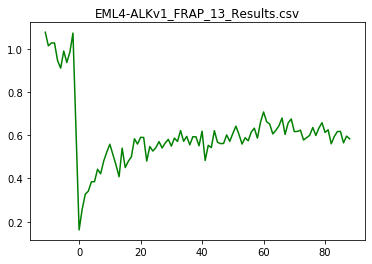

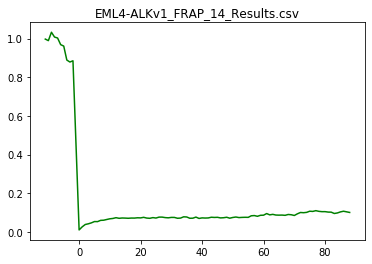

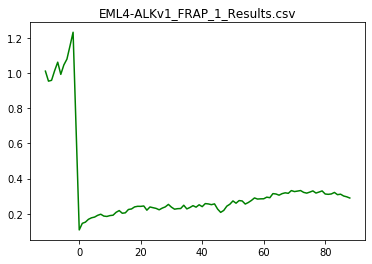

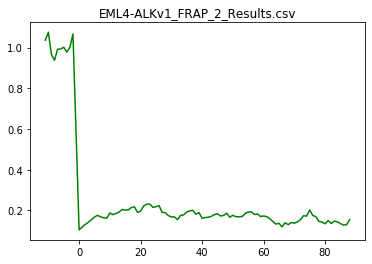

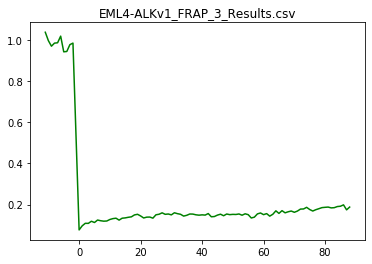

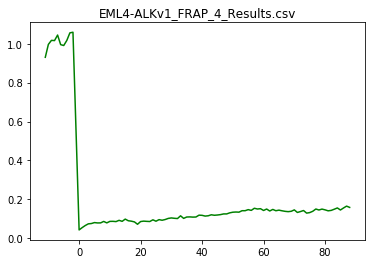

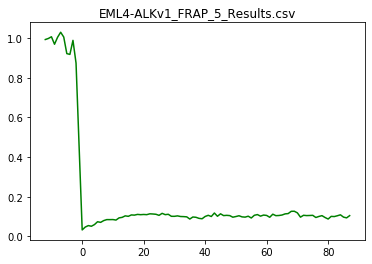

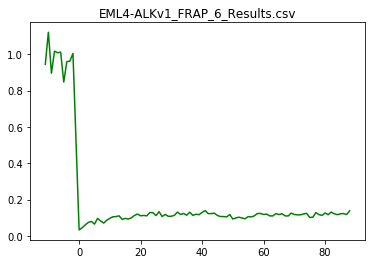

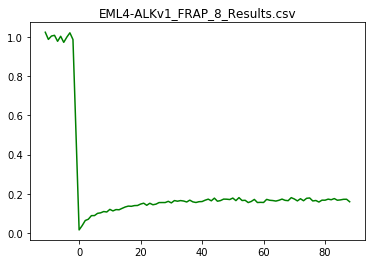

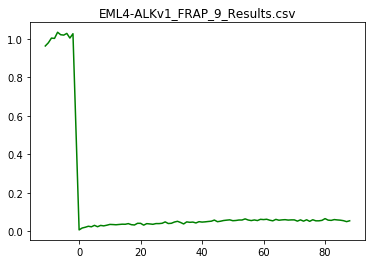

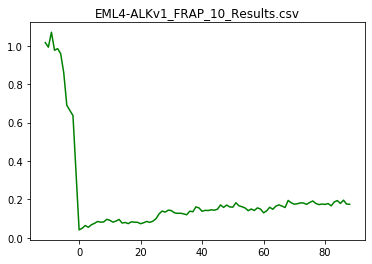

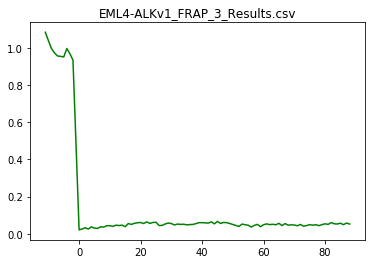

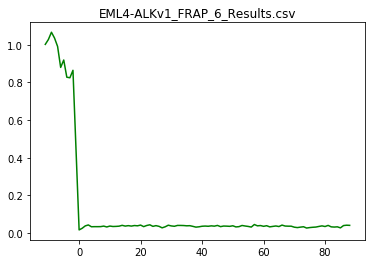

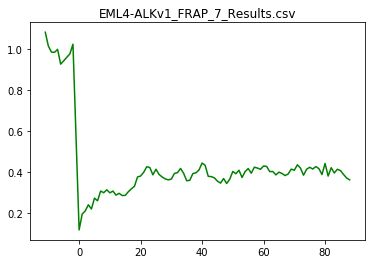

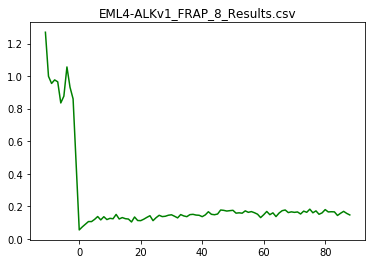

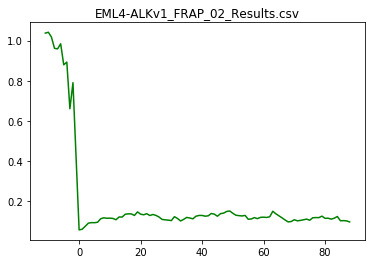

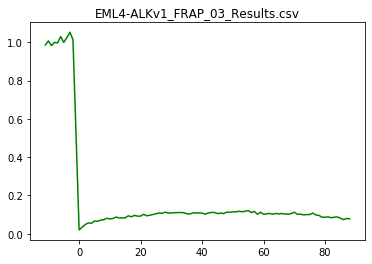

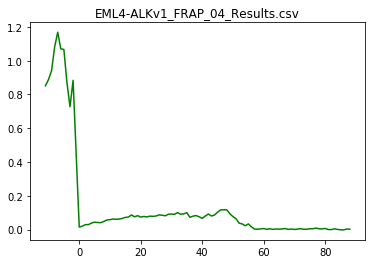

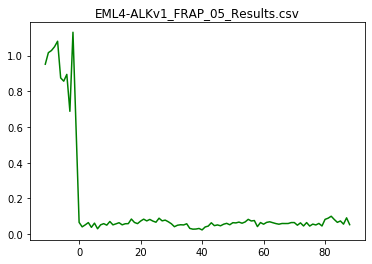

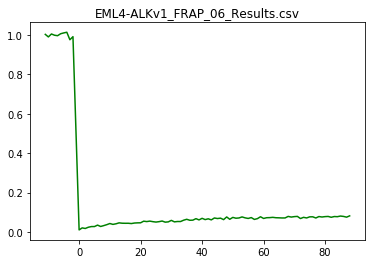

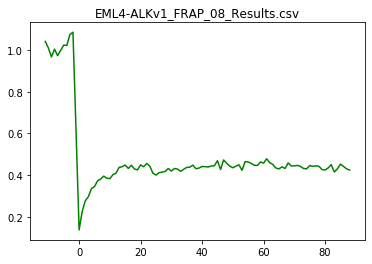

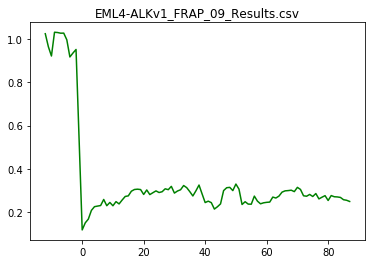

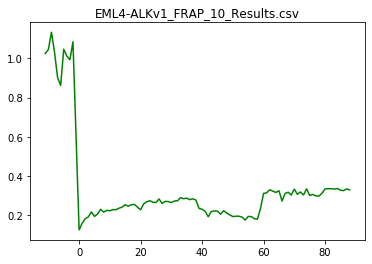

In [215]:
# Drop the prebleach frame
ROI = 'Mean(Focus)'

for f in ALKv1.File.unique():
    
    file_data = ALKv1[ALKv1.File.eq(f)]

    title = file_data.Filename.values[0]
    t0    = file_data['Bleach Frame'].values[0]
    
    df    = four_column(file_data)
    sub   = subtract_background(df)
    norm  = normalise(sub)
    FRAP = get_FRAP(norm, t0)
    
    #Drop prebleach frame
    prebleachframe = FRAP[FRAP['Time']==-1].index.values
    FRAP.drop(index=prebleachframe, inplace=True)

    x = FRAP.Time
    y = FRAP[ROI]
    plt.plot(x, y, c='g');
    plt.title(title);
    plt.show()

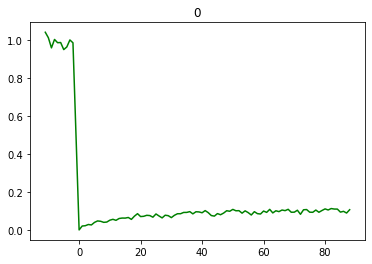

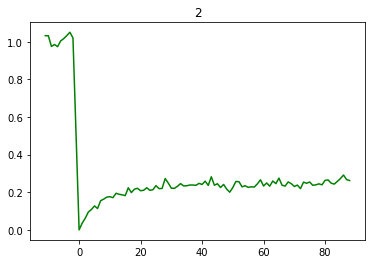

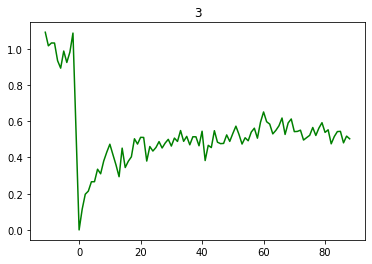

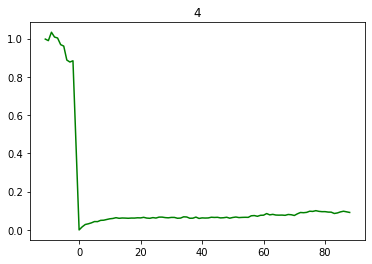

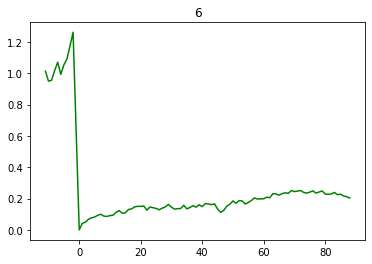

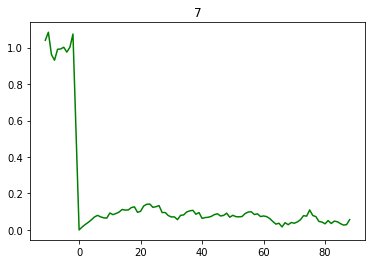

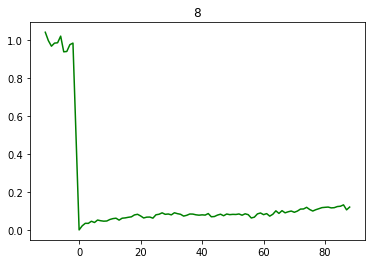

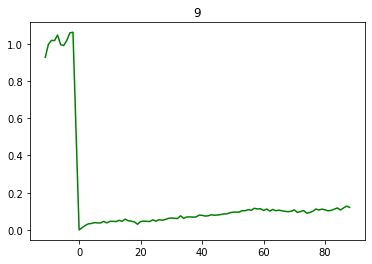

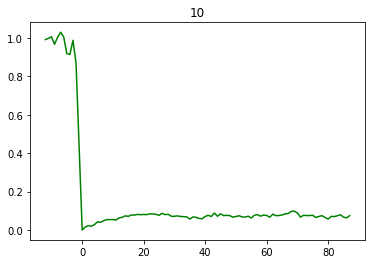

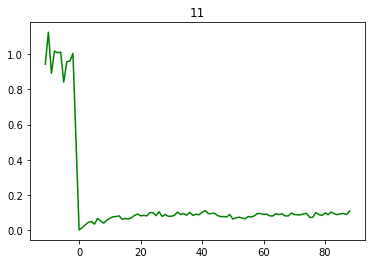

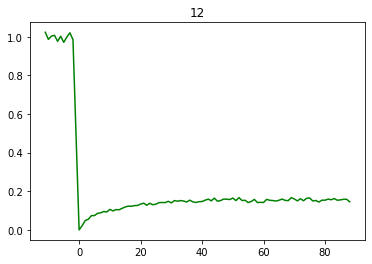

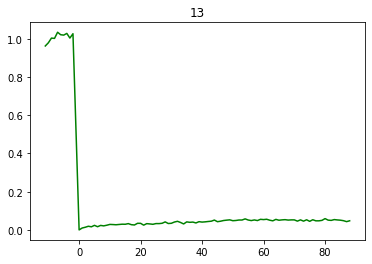

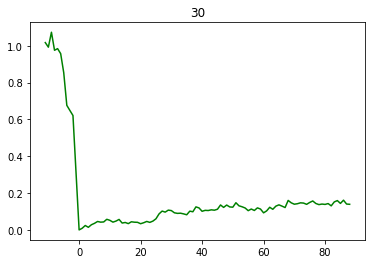

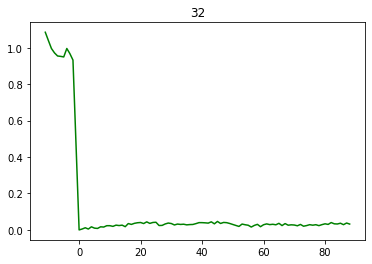

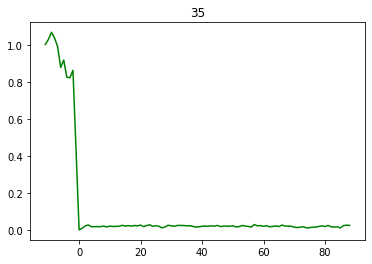

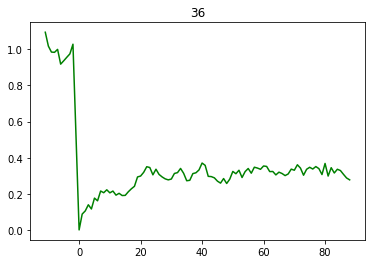

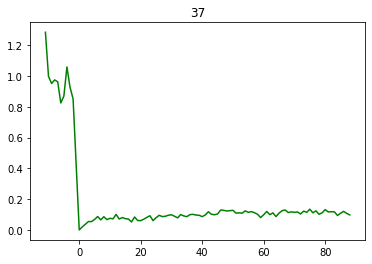

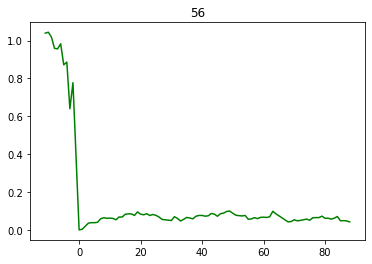

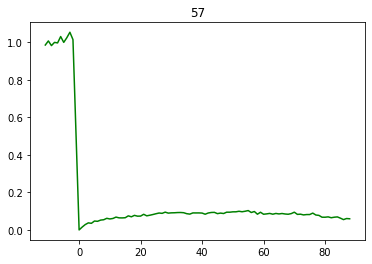

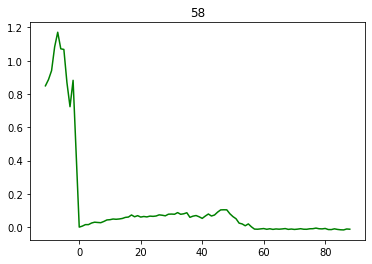

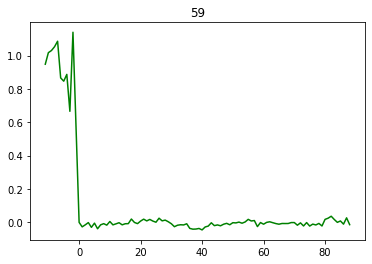

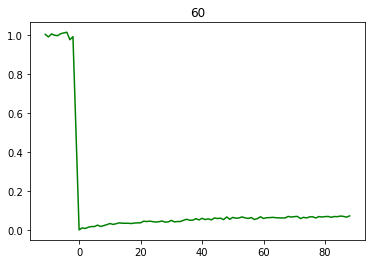

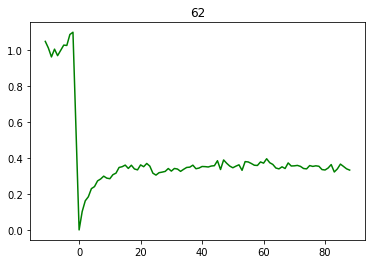

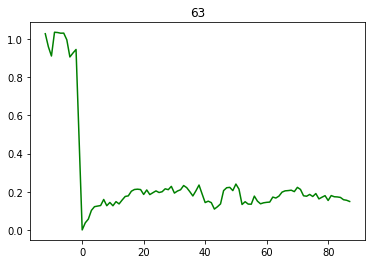

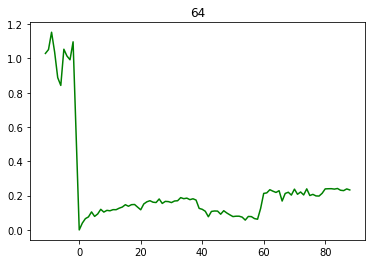

In [198]:
# Normalise to 0-1 range
ROI = 'Mean(Focus)'

for f in ALKv1.File.unique():
    
    file_data = ALKv1[ALKv1.File.eq(f)]

    title = file_data.Filename.values[0]
    t0    = file_data['Bleach Frame'].values[0]
    
    df    = four_column(file_data)
    sub   = subtract_background(df)
    norm  = normalise(sub)
    FRAP  = get_FRAP(norm, t0)

    #Drop prebleach frame
    prebleachframe = FRAP[FRAP['Time']==-1].index.values
    FRAP.drop(index=prebleachframe, inplace=True)
    
    x = FRAP.Time
    y = FRAP[ROI]
    
    #Normalise to 0-1 range
    y = 1 / (1-y.loc[int(prebleachframe)+1])*(y-1)+1

    plt.plot(x, y, c='g');
    plt.title(f);
    plt.show()

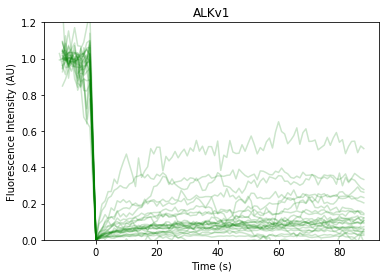

In [221]:
# Normalise to 0-1 range
ROI = 'Mean(Focus)'

for f in ALKv1.File.unique():
    
    file_data = ALKv1[ALKv1.File.eq(f)]

    title = file_data.Filename.values[0]
    t0    = file_data['Bleach Frame'].values[0]
    
    df    = four_column(file_data)
    sub   = subtract_background(df)
    norm  = normalise(sub)
    FRAP  = get_FRAP(norm, t0)

    #Drop prebleach frame
    prebleachframe = FRAP[FRAP['Time']==-1].index.values
    FRAP.drop(index=prebleachframe, inplace=True)
    
    x = FRAP.Time
    y = FRAP[ROI]
    
    #Normalise to 0-1 range
    y = 1 / (1-y.loc[int(prebleachframe)+1])*(y-1)+1

    plt.plot(x, y, c='g', alpha=0.2);
    plt.title('ALKv1');
    plt.xlabel('Time (s)');
    plt.ylabel('Fluorescence Intensity (AU)');
    plt.ylim(0,1.2);
    
    plt.savefig('Figures/ALKv1_80s_0-1.pdf', format='pdf')

In [217]:
ALKv3 = publication_data[publication_data.Protein.eq('ALKv3')]

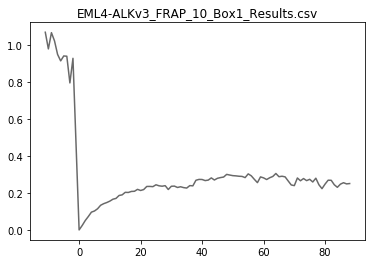

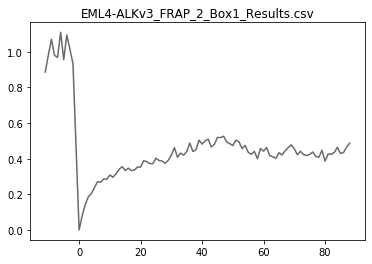

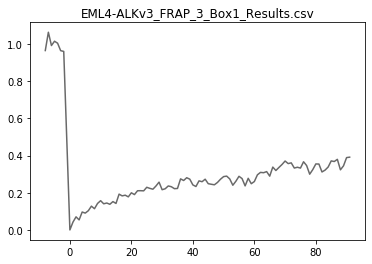

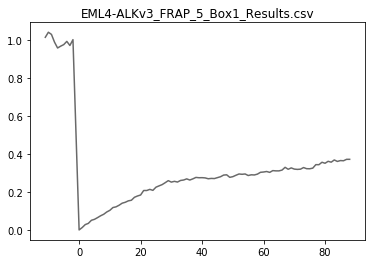

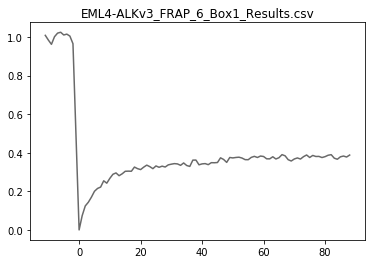

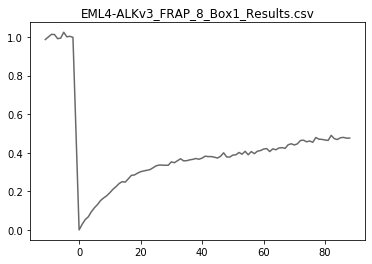

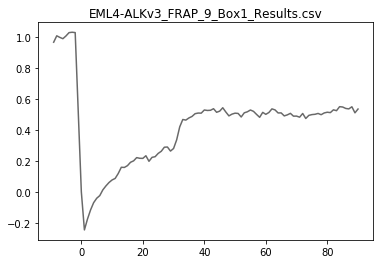

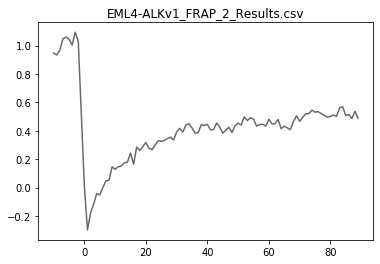

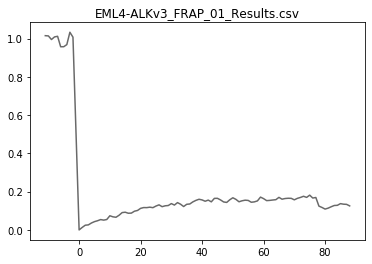

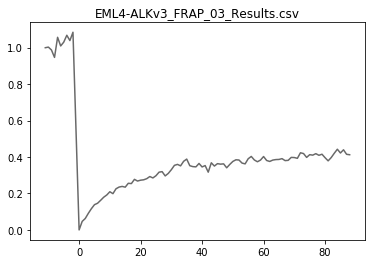

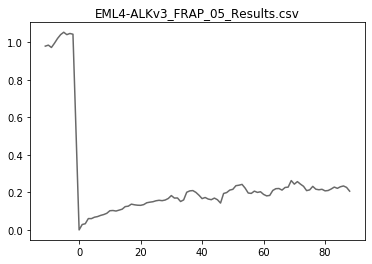

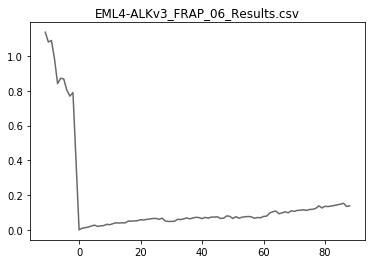

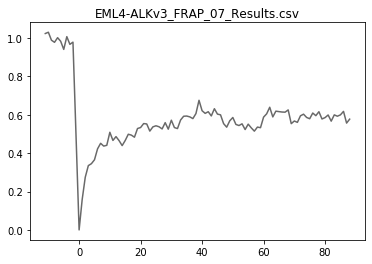

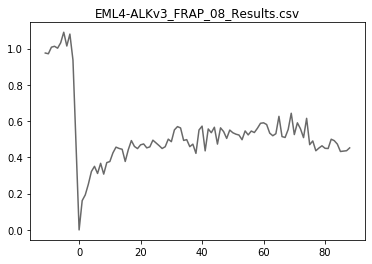

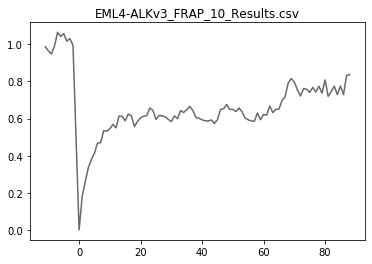

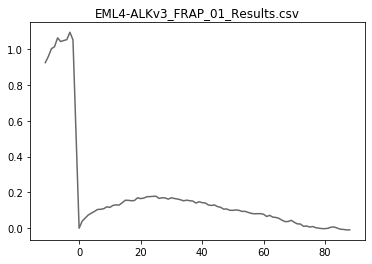

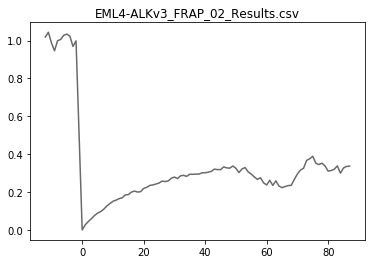

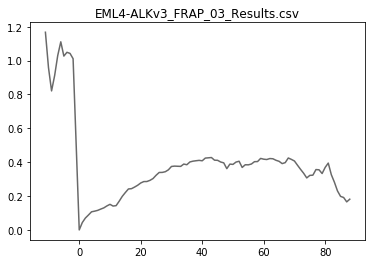

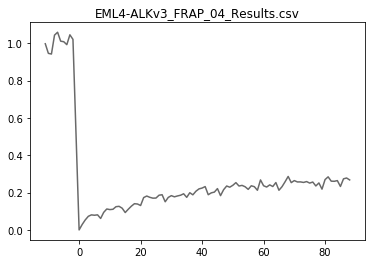

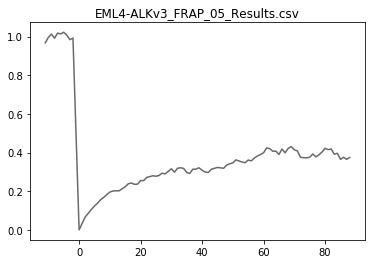

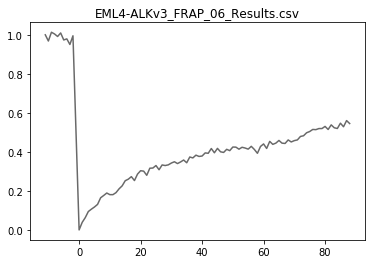

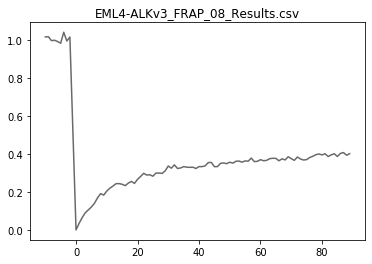

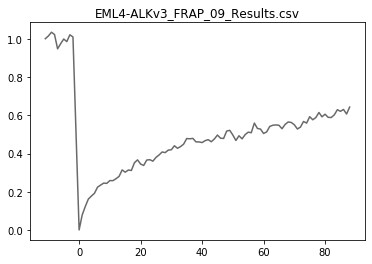

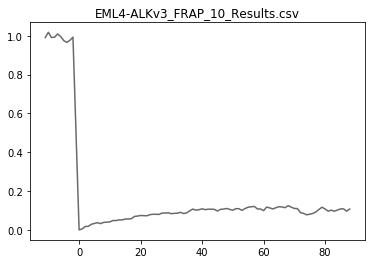

In [219]:
# Normalise to 0-1 range
ROI = 'Mean(Focus)'

for f in ALKv3.File.unique():
    
    file_data = ALKv3[ALKv3.File.eq(f)]

    title = file_data.Filename.values[0]
    t0    = file_data['Bleach Frame'].values[0]
    
    df    = four_column(file_data)
    sub   = subtract_background(df)
    norm  = normalise(sub)
    FRAP  = get_FRAP(norm, t0)

    #Drop prebleach frame
    prebleachframe = FRAP[FRAP['Time']==-1].index.values
    FRAP.drop(index=prebleachframe, inplace=True)
    
    x = FRAP.Time
    y = FRAP[ROI]
    
    #Normalise to 0-1 range
    y = 1 / (1-y.loc[int(prebleachframe)+1])*(y-1)+1

    plt.plot(x, y, c='dimgrey');
    plt.title(title);
    plt.show()

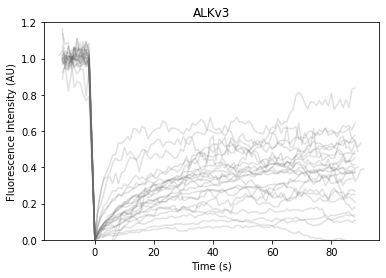

In [222]:
# Normalise to 0-1 range
ROI = 'Mean(Focus)'

for f in ALKv3.File.unique():
    
    file_data = ALKv3[ALKv3.File.eq(f)]

    title = file_data.Filename.values[0]
    t0    = file_data['Bleach Frame'].values[0]
    
    df    = four_column(file_data)
    sub   = subtract_background(df)
    norm  = normalise(sub)
    FRAP  = get_FRAP(norm, t0)

    #Drop prebleach frame
    prebleachframe = FRAP[FRAP['Time']==-1].index.values
    FRAP.drop(index=prebleachframe, inplace=True)
    
    x = FRAP.Time
    y = FRAP[ROI]
    
    #Normalise to 0-1 range
    y = 1 / (1-y.loc[int(prebleachframe)+1])*(y-1)+1

    plt.plot(x, y, c='dimgrey', alpha=0.2);
    plt.title('ALKv3');
    plt.xlabel('Time (s)');
    plt.ylabel('Fluorescence Intensity (AU)');
    plt.ylim(0, 1.2);
    
    plt.savefig('Figures/ALKv3_80s_0-1.pdf', format='pdf')

# Fit FRAP curves

In [224]:
# Start with a single example

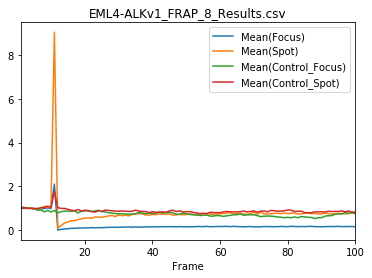

In [225]:
file_num = 12

file_data = publication_data[publication_data.File.eq(file_num)]

title = file_data.Filename.values[0]
t0    = file_data['Bleach Frame'].values[0]

df    = six_column(file_data)
sub   = subtract_background(df)
norm  = normalise(sub)

norm.plot(x='Frame');
plt.title(title);

In [16]:
# Fit this curve and report the Mobile Fraction.

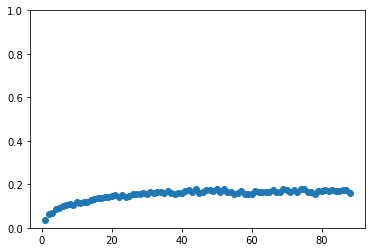

In [227]:
# Plot just the Mean(Focus)
ROI = 'Mean(Focus)'

post_bleach = norm[t0:].copy()
post_bleach['Time'] = (post_bleach['Frame']-t0)
plt.scatter(x=post_bleach['Time'], y=post_bleach[ROI]);
plt.ylim(0,1);

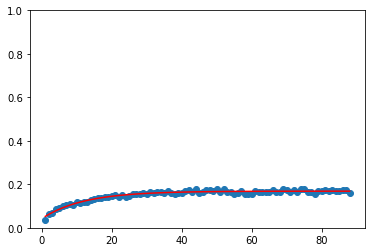

In [228]:
#Fit this FRAP experiment
x = np.array(post_bleach['Time'])   
y0 = np.array(post_bleach[ROI])

plt.scatter(x, y0);
plt.ylim(0,1);

A= 0.7
c= 0.6
h= 0.5

p0 = [A, c, h]
bounds = (0.1, 0.1, 0), (1, 90, 1)

y1, p1, e1 = fit_exp(x, y0, p0, bounds)

plt.plot(x, y1, c='r');

0.16841187188079085  -  0.052527167448430695  =  0.1223092636020809


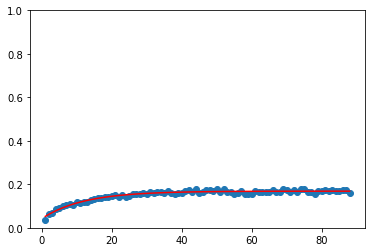

In [229]:
## Report the Mobile Fraction
x = np.array(post_bleach['Time'])   
y0 = np.array(post_bleach[ROI])

plt.scatter(x, y0);
plt.ylim(0,1);

A= 0.7
c= 0.6
h= 0.5

p0 = [A, c, h]
bounds = (0.1, 0.1, 0), (1, 90, 1)

y1, p1, e1 = fit_exp(x, y0, p0, bounds)

plt.plot(x, y1, c='r');

M = get_mobile_from_fit(y1)

print(y1.max(), ' - ', y1.min(), ' = ', M)

In [244]:
fit_list   = list()
thalf_list = list()
M_list     = list()

#Initialize
A= 0.7
c= 0.6
h= 0.5

p0 = [A, c, h]
bounds = (0.1, 0.1, 0), (1, 90, 1)

for f in publication_data.File.unique():
    
    file_data = publication_data[publication_data.File.eq(f)]
    
    title = file_data.Filename.values[0]
    t0    = file_data['Bleach Frame'].values[0]
    
    df    = four_column(file_data)
    sub   = subtract_background(df)
    norm  = normalise(sub)
    FRAP  = get_FRAP(norm, t0)

    #Drop prebleach frame
    prebleachframe = FRAP[FRAP['Time']==-1].index.values
    
    x = FRAP.Time
    y = FRAP[ROI]
    
    
    #Drop prebleach frames
    prebleachframe = int(FRAP[FRAP['Time']==-1].index.values)
    postbleach_FRAP = FRAP.loc[int(prebleachframe+1):].copy()
       
    x = np.array(postbleach_FRAP.Time)   
    y0 = np.array(postbleach_FRAP[ROI])

    y1, p1, e1 = fit_exp(x, y0, p0, bounds)
    
    thalf = get_thalf(x, y1)
    
    M = get_mobile_from_fit(y1)

    fit_list.append(y1)
    thalf_list.append(thalf)
    M_list.append(M)

In [ ]:
# Shape results into DataFrame

In [275]:
Mobile = pd.DataFrame()
Mobile['File'] = publication_data.File.unique()
Mobile['M']    = M_list
Mobile

,File,M
0,0,0.100983
1,2,0.231080
2,3,0.476277
3,4,0.098496
4,6,0.192061
5,7,0.107947
6,8,0.075385
7,9,0.099426
8,10,0.100476
9,11,0.101670


In [267]:
publication_data.head(1)

,Frame,Mean(Focus),Mean(Spot),Mean(Bgd),Mean(Control_Focus),Mean(Control_Spot),Protein,File,Filename,Experiment,Bleach Frame
0,1,274.639,127.306,113.549,409.495,124.577,ALKv1,0,EML4-ALKv1_FRAP_10_Results.csv,C:/Users/David Brown/Documents/Huang Lab/EML4-...,12


In [274]:
Results = publication_data[['File', 'Filename', 'Experiment', 'Protein']].copy()
Results['Duplicate'] = Results.duplicated()
Results = Results[Results.Duplicate == False]
Results.reset_index(drop=True, inplace=True)
Results

,File,Filename,Experiment,Protein,Duplicate
0,0,EML4-ALKv1_FRAP_10_Results.csv,C:/Users/David Brown/Documents/Huang Lab/EML4-...,ALKv1,False
1,2,EML4-ALKv1_FRAP_12_Results.csv,C:/Users/David Brown/Documents/Huang Lab/EML4-...,ALKv1,False
2,3,EML4-ALKv1_FRAP_13_Results.csv,C:/Users/David Brown/Documents/Huang Lab/EML4-...,ALKv1,False
3,4,EML4-ALKv1_FRAP_14_Results.csv,C:/Users/David Brown/Documents/Huang Lab/EML4-...,ALKv1,False
4,6,EML4-ALKv1_FRAP_1_Results.csv,C:/Users/David Brown/Documents/Huang Lab/EML4-...,ALKv1,False
5,7,EML4-ALKv1_FRAP_2_Results.csv,C:/Users/David Brown/Documents/Huang Lab/EML4-...,ALKv1,False
6,8,EML4-ALKv1_FRAP_3_Results.csv,C:/Users/David Brown/Documents/Huang Lab/EML4-...,ALKv1,False
7,9,EML4-ALKv1_FRAP_4_Results.csv,C:/Users/David Brown/Documents/Huang Lab/EML4-...,ALKv1,False
8,10,EML4-ALKv1_FRAP_5_Results.csv,C:/Users/David Brown/Documents/Huang Lab/EML4-...,ALKv1,False
9,11,EML4-ALKv1_FRAP_6_Results.csv,C:/Users/David Brown/Documents/Huang Lab/EML4-...,ALKv1,False


In [277]:
# Merge with other data
Results = Results.merge(Mobile, on='File')
Results

,File,Filename,Experiment,Protein,Duplicate,M
0,0,EML4-ALKv1_FRAP_10_Results.csv,C:/Users/David Brown/Documents/Huang Lab/EML4-...,ALKv1,False,0.100983
1,2,EML4-ALKv1_FRAP_12_Results.csv,C:/Users/David Brown/Documents/Huang Lab/EML4-...,ALKv1,False,0.231080
2,3,EML4-ALKv1_FRAP_13_Results.csv,C:/Users/David Brown/Documents/Huang Lab/EML4-...,ALKv1,False,0.476277
3,4,EML4-ALKv1_FRAP_14_Results.csv,C:/Users/David Brown/Documents/Huang Lab/EML4-...,ALKv1,False,0.098496
4,6,EML4-ALKv1_FRAP_1_Results.csv,C:/Users/David Brown/Documents/Huang Lab/EML4-...,ALKv1,False,0.192061
5,7,EML4-ALKv1_FRAP_2_Results.csv,C:/Users/David Brown/Documents/Huang Lab/EML4-...,ALKv1,False,0.107947
6,8,EML4-ALKv1_FRAP_3_Results.csv,C:/Users/David Brown/Documents/Huang Lab/EML4-...,ALKv1,False,0.075385
7,9,EML4-ALKv1_FRAP_4_Results.csv,C:/Users/David Brown/Documents/Huang Lab/EML4-...,ALKv1,False,0.099426
8,10,EML4-ALKv1_FRAP_5_Results.csv,C:/Users/David Brown/Documents/Huang Lab/EML4-...,ALKv1,False,0.100476
9,11,EML4-ALKv1_FRAP_6_Results.csv,C:/Users/David Brown/Documents/Huang Lab/EML4-...,ALKv1,False,0.101670


In [288]:
Results.groupby('Protein').count()

,File,Filename,Experiment,Duplicate,M
Protein,,,,,
ALKv1,25,25,25,25,25
ALKv3,24,24,24,24,24


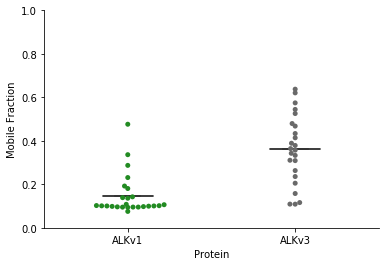

In [283]:
## Plot all ALKv1 and ALKv3 traces
colors = ["forestgreen", "dimgrey"]
# Set your custom color palette
sns.set_palette(sns.color_palette(colors))

sns.boxplot('Protein', 'M', data=Results.groupby(by='Protein').mean().reset_index(), width=0.3)
sns.swarmplot('Protein', 'M', data=Results)
sns.despine()
plt.ylim(0,1);
plt.ylabel('Mobile Fraction');

plt.savefig('Figures/EML4-ALK_80s_Mobile_Fractions_Swarm.pdf', format='pdf')

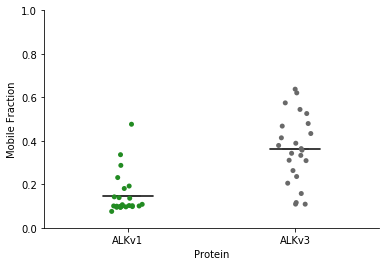

In [287]:
## Plot all ALKv1 and ALKv3 traces
colors = ["forestgreen", "dimgrey"]
# Set your custom color palette
sns.set_palette(sns.color_palette(colors))

sns.boxplot('Protein', 'M', data=Results.groupby(by='Protein').mean().reset_index(), width=0.3)
sns.stripplot('Protein', 'M', data=Results)
sns.despine()
plt.ylim(0,1);
plt.ylabel('Mobile Fraction');

# plt.savefig('Figures/EML4-ALK_80s_Mobile_Fractions_Strip.pdf', format='pdf')